# 🔊 UrbanSound8K Classification (USC)

Bienvenue !

#### Rappel du sujet

Ce notebook a pour objet l'étude de la classification de sons provenant de la librarie [UrbanSound8K datasets](https://urbansounddataset.weebly.com/urbansound8k.html).

Il question à travers ce projet, d'appréhender des notions théoriques relatives aux traitements de sons et ainsi implémenter un modèle de classification "from scratch" basé sur des réseaux de neurones.

Nous utiliserons des fichiers de sons au format [WAV](https://en.wikipedia.org/wiki/WAV) ainsi que leurs métadata correspondant dans un tableau csv. 

Dans un premier temps, nous allons charger et explorer l'ensemble des données et méta-données de la dataset UrbanSound8K afin d'étudier différentes métriques qui seront essentielles à la création du modèle de classification.


Suite à cela, nous étudierons les concepts théoriques “Mel-spectogram“ et “Mel-frequency cepstral coefficients“ qui nous permettrons de construire un un dataframe afin de mettre en place nos réseaux de neurones.


## Pré-requis 🚨🚨🚨

Définir la base du chemin d'accès aux fichiers en fonction de votre environement.
exemple : 

"../\__MONCHEMIN__/\__DOSSIER_DU_CSV_ET_DES_FOLDS__/"

In [2]:
base_path = "../input/urbansound8k/"

## Import des divers packages nécessaires à cette étude

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

import multiprocessing as mp
import functools
import gc
import time

import librosa as lisa
import librosa.display

from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, MaxPooling2D, Dense, Dropout,BatchNormalization, Activation, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

### 1. Exploration des données

Dans un premier temps, nous allons explorer les datasets fournis pour comprendre quel type de données nous avons, comment les traiter et les classifier.

In [4]:
df = pd.read_csv(base_path + "UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Ce fichier comprend les colonnes suivantes :

* slice_file_name: 
Le nom du fichier audio. Le nom est formaté de la manière suivante : [fsID]-[classID]-[occurrenceID]-[sliceID].wav, où :

   - fsID = L'identifiant Freesound de l'enregistrement d'où est issu cet extrait.
    
   - classID = L'identifiant numérique de la classe de son auquel cet extrait appartient. (voir la description de classID ci-dessous pour plus de détails).
    
   - occurenceID = L'identifiant numérique permettant de dinstinguer les différentes occurences de ce son dans l'enregistrement original.
   
   - sliceID = L'identifiant numérique pour distinguer les différentes tranches issues de la même occurence sonore.

* fsID:
L'identifiant Freesound de l'enregistrement d'où est issu cet extrait.

* start
Le temps de départ de l'extrait dans l'enregistrement Freesound original.

* end:
Le temps de fin de l'extrait dans l'enregistrement Freesound original.

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
Une évaluation (subjective) de l'importance du son. 1 = premier plan, 2 = arrière-plan.

* fold:
Le numéro de répertoire (1 - 10) auquel le fichier a été alloué.

* classID:
L'identifiant numérique de la classe de son :
        - 0 = Climatiseur (air_conditioner)
        - 1 = Avertisseur sonore de voiture (car_horn)
        - 2 = Enfants en train de jouer (children_playing)
        - 3 = Aboiements de chiens (dog_bark)
        - 4 = Perçage (drilling)
        - 5 = Moteur au ralenti (engine_idling)
        - 6 = Coup de feu (gun_shot)
        - 7 = Marteau piqueur (jackhammer)
        - 8 = Sirène (siren)
        - 9 = Musique de rue (street_music)


* class:
Le nom de la classe (listées ci-dessus).

In [5]:
df.shape

(8732, 8)

Le dataset contient 8 colonnes pour 8 732 lignes de données. Cela signifie que nous disposons de 8 732 extraits de sons.

In [6]:
df.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


Ce tableau nous apprends que le tableau de données est complet, en effet la ligne *count* nous apprend que toutes les colonnes contiennent 8732 lignes de données.

### 2. Librosa library

Librosa est une librarie python pour l'analyse musicale et audio. Elle fournit les éléments de base nécessaires à la création de systèmes de recherche d'informations musicales.

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6759664.svg)](https://doi.org/10.5281/zenodo.6759664)


#### Les principales fonctionnalités de Librosa

* librosa.beat :
Fonctions pour estimer le tempo et détecter les évènements rythmiques.

* librosa.core :
Les fonctionnalités **Core** prend en charge des fonctionnalités de chargements depuis un espace de stockage, réalise diverses représentations de spectrogrammes ainsi qu'une variété d'outils pour l'analyse musicale.

* librosa.decompose :
Fonctions pour la séparation des sources harmoniques-percussives (HPSS) et la decomposition générique des spectrogrammes en utilisant les méthodes de matrices de décompositions implémentées dans *scikit-learn*.

* librosa.display :
Virtualisations et affichage de routines utilisant *matplotlib*.

* librosa.effects :
Traitement audio dans le domaine temporel, tel que le pitch shifting et le time stretching. Ce sous-module fournit également des enveloppes temporelles pour le sous-module decompose détaillé ci-dessus.

* librosa.feature : 
Extraction et manipulation des caracteristiques. Sont inclu des fonctionnalités d'extraction de bas niveau, comme des chromagrammes, des spectogrammes Mel, MFCC.

Pour en savoir plus, nous vous invitons à consulter la [documentation officielle de Librosa](https://librosa.org/doc/main/tutorial.html)

<sub><sup>Source : Documentation de la librairie Librosa.</sup></sub>

## Exemple d'utilisation de la méthode load

La méthode load nous retourne 2 variables. 
La première est **y** et représente le fichier audio comme étant plusieurs séries chronologiques audio. La seconde, **sr**, représente la fréquence d'échantillonnage.

In [7]:
y, sr = lisa.load(base_path + 'fold5/100032-3-0-0.wav')
print("Shape :", y.shape)
print("Sampling rate: ", sr)

Shape : (7002,)
Sampling rate:  22050


On observe que la forme de **y** est un tableau à une dimension, ce qui d'après la librairie Librosa, que le son est un son mono.

En effet, cela est normal puisque par défaut la libraire convertit les sons en mono.
Nous pourrons influencer sur cela grâce au paramètre **mono** qui est par défaut défini à **True**.

### 3. Format WAV

Le Waveform Audio File Format (WAVE, ou WAV en rapport avec son extension de fichier), est un format conteneur destiné au stockage de l'audio numérique mis au point par Microsoft et IBM. 

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://i.stack.imgur.com/Q9xGC.jpg" 
    alt="Canonical wave file structure">
</img>

#### En-têtes de fichiers
L'en-tête d'un fichier WAV contient plusieurs blocs. 
- En premier, nous avons le **bloc de déclaration**, qui fournit les information sur le fichier wav, comme son format et la taille du fichier. Ce bloc est hériter du RIFF. 
- Ensuite nous avons le **bloc d'écrivant le format audio**. Ce bloc est particulièrement intéressant car il fournit des information comme la fréquence d'échantillonage (en herzt) , le nombre de canaux (1 mono, 2 stéréo) et d'autres informations [wiki]().
- Enfin le **bloc de données**, ou sont stocké les octets des samples de chaque canal.


### 4. Quelques définitions

- **Frequence** : La fréquence est une caractéristique du son qui indique le nombre de vibrations par seconde exprimé en Hertz (Hz). $f= \frac{1}{T}$ $f$ : frequence (Hz) et $T$ : temps pour effectuer un cycle (s).

- **Amplitude** : La magnitude des alternances de pression acoustique, mesurée à partir de 0, est appelée amplitude.

- **Nombre de canaux** : Represente le canal utilisé. 1 pour Mono et 2 pour Stéréo. Par exemple, sur un casque traditionnel un son mono ne pourra être émis que par un seul écouteur, tandis qu'un son stéréo pourra être émis par deux écouteurs.

- **Frequence d'echantillonage** : La fréquence d'échantillonnage utilisée en audio est le nombre d'échantillons pris par seconde pour enregistrer une piste audio. Il indique combien de fois par seconde l'audio est échantillonné lors de sa conversion de l'analogique au numérique.


### 5. Amplitude

Nous allons visualiser quelques échantillons de chaque classes afin d'observer s'il existe une différence notable entre chaque type de sons.

In [8]:
# Définition d'un dictionnaire contenant les différentes types de classes
labels = df[['classID', 'class']].value_counts().keys().sort_values()
label_dict = dict(labels)
label_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

Nous définissions ici un ensemble de 4 fonctions afin d'optimiser le code nécessaire à l'affichage des différents graphiques.

In [9]:
@functools.lru_cache(maxsize=None)
def load_wave(folder, file_name):
    y, sr = lisa.load(base_path + 'fold' + folder + '/' + file_name, sr=None, mono=False)
    return y, sr
    
def get_audio_file_by_classId(data,classId) :
    file_locations = [[row['fold'], row['slice_file_name']] for index, row in data[data['classID'] == classId].reset_index().iterrows()]
    return file_locations

def get_sample_by_classId(data, sample, classId):
    groups = data.groupby("classID").sample(sample)
    return get_audio_file_by_classId(groups,classId)

def plot_amplitude(classId, sample):
    files = get_sample_by_classId(df,sample,classId)
    fig, ax = plt.subplots(nrows=sample,sharex='all', figsize=(20,10))
    for idx, file in enumerate(files) :
        y, sr = load_wave(f'{file[0]}',f'{file[1]}')
        ax[idx].set_ylim(ymin=0)
        lisa.display.waveshow(y, sr=22050,ax=ax[idx])
        ax[idx].set_title(f'File: {file[1]}')
        
    fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
    plt.suptitle(f"Classe : {label_dict[classId]}", fontsize=14)
    
    fig.subplots_adjust(hspace=0.4)    
    plt.show()
    plt.rcParams['axes.grid'] = True
    


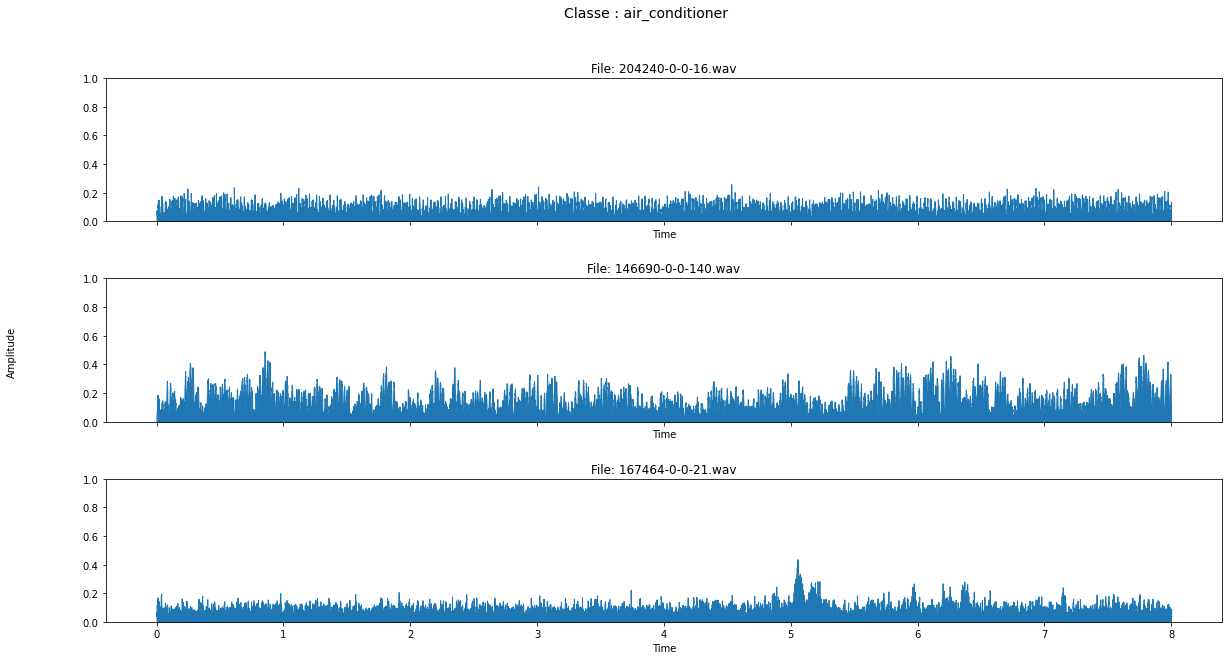

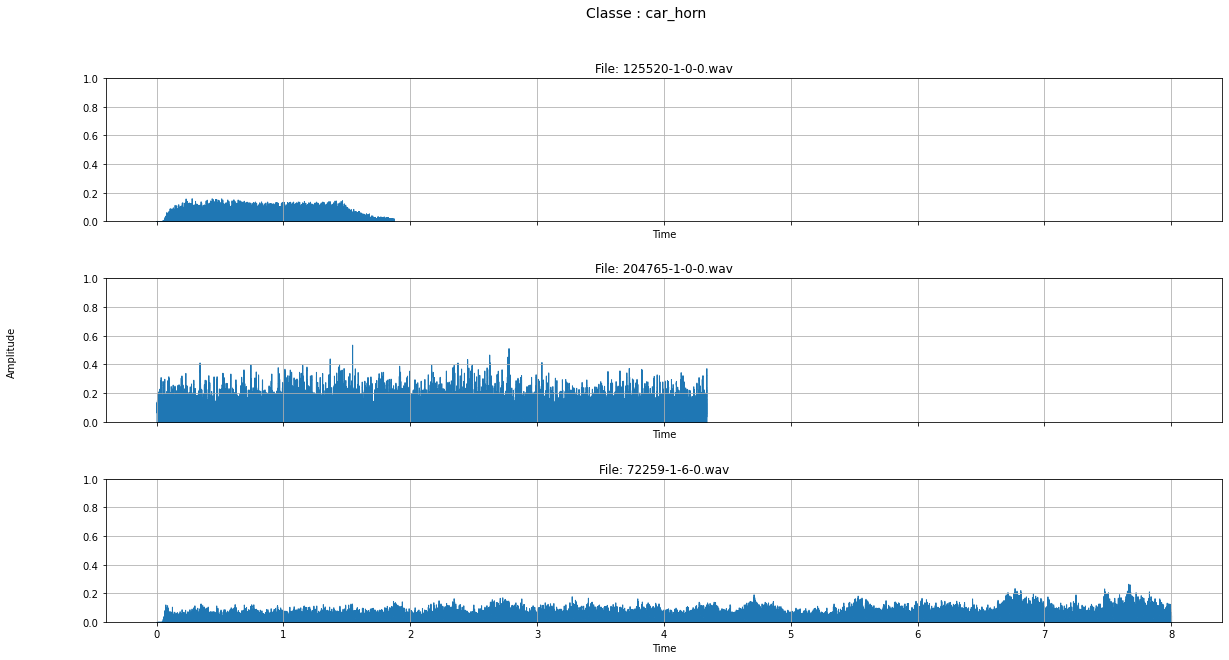

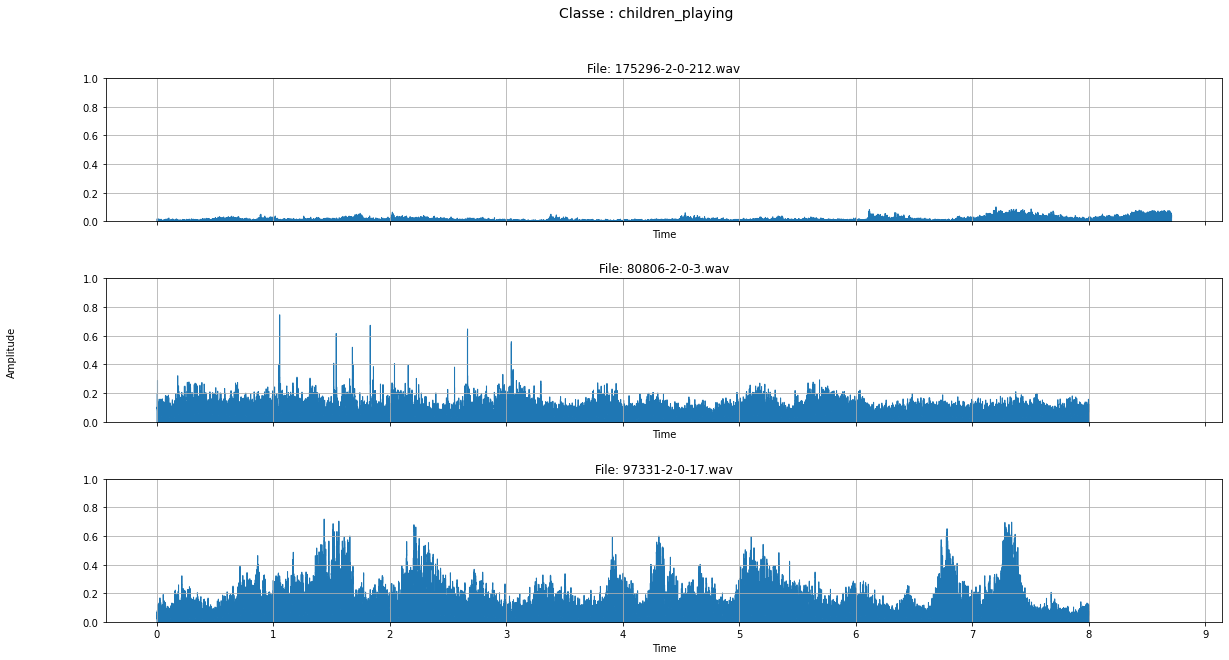

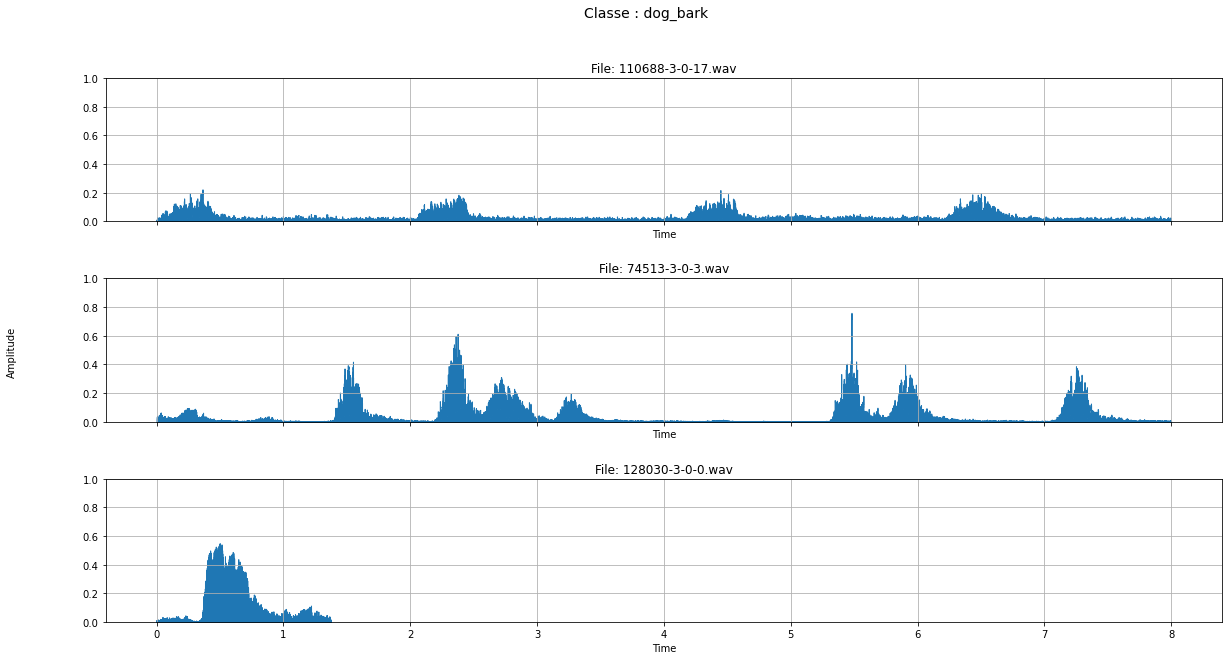

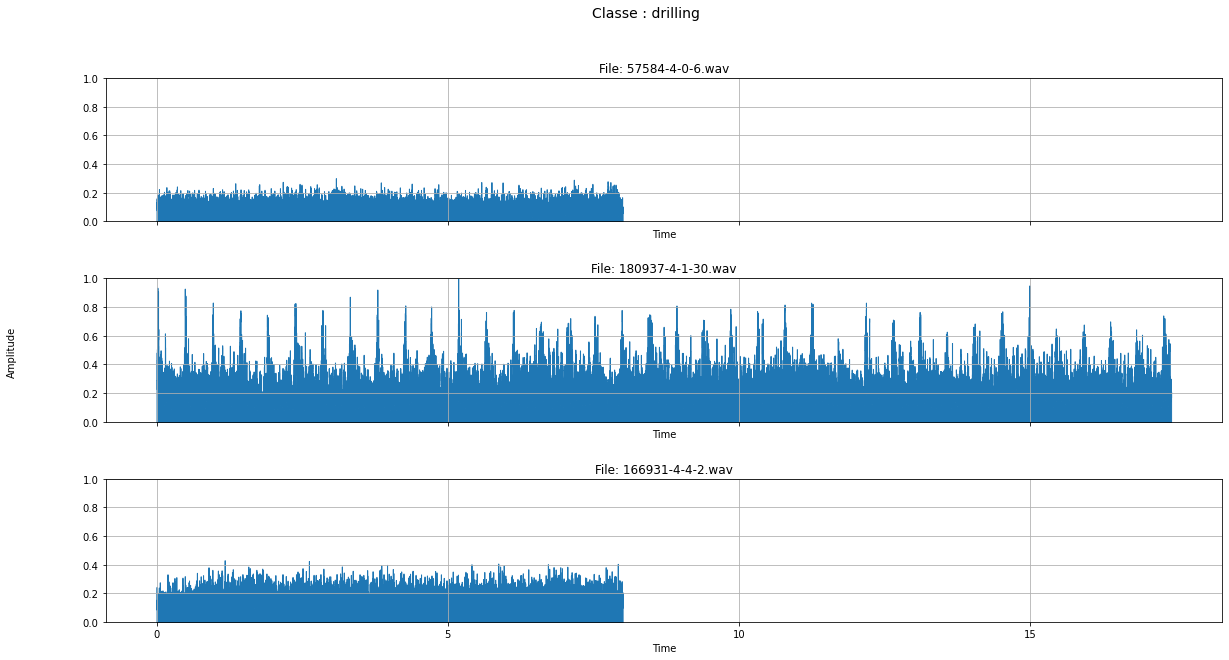

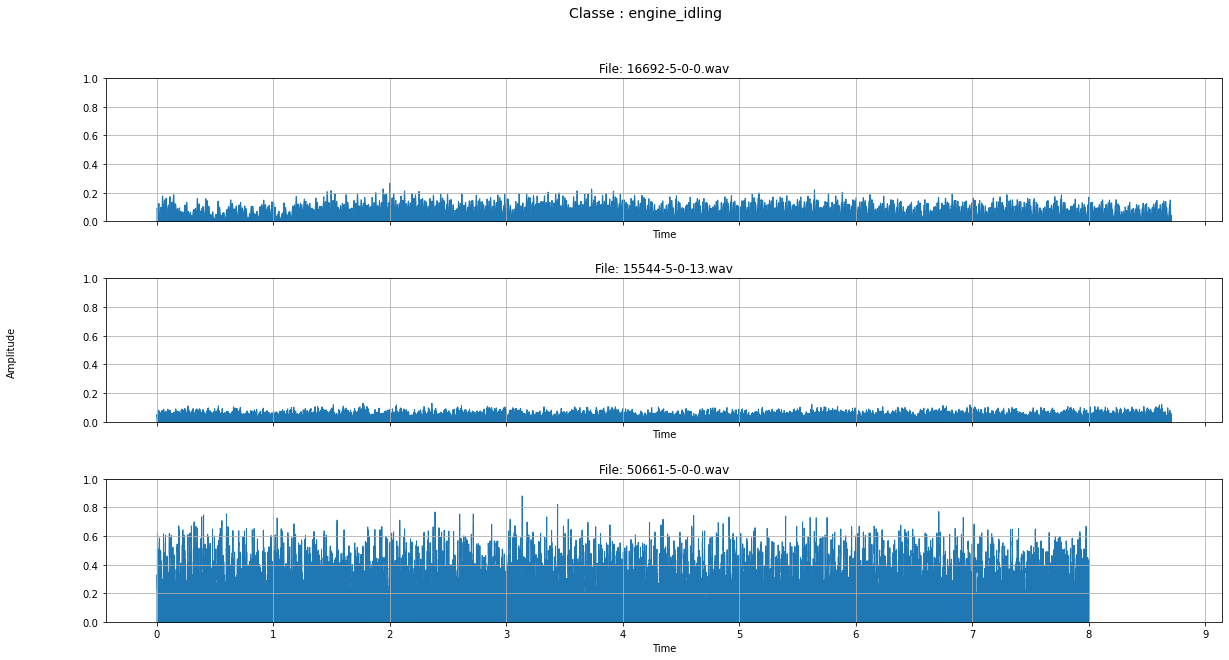

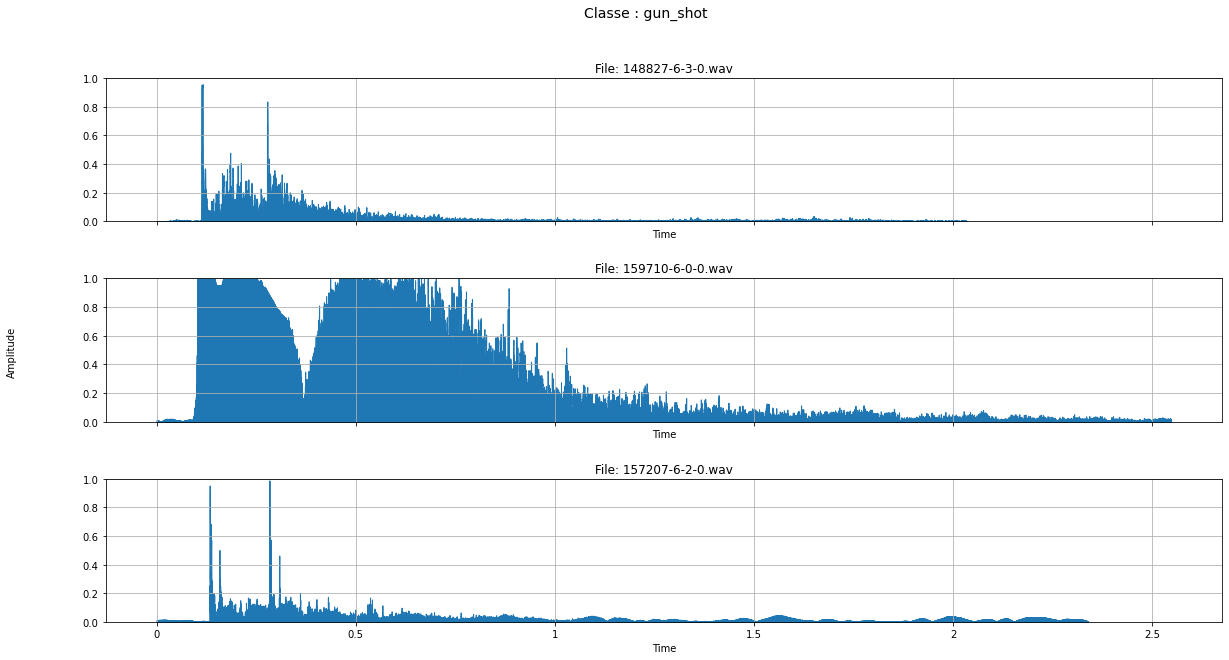

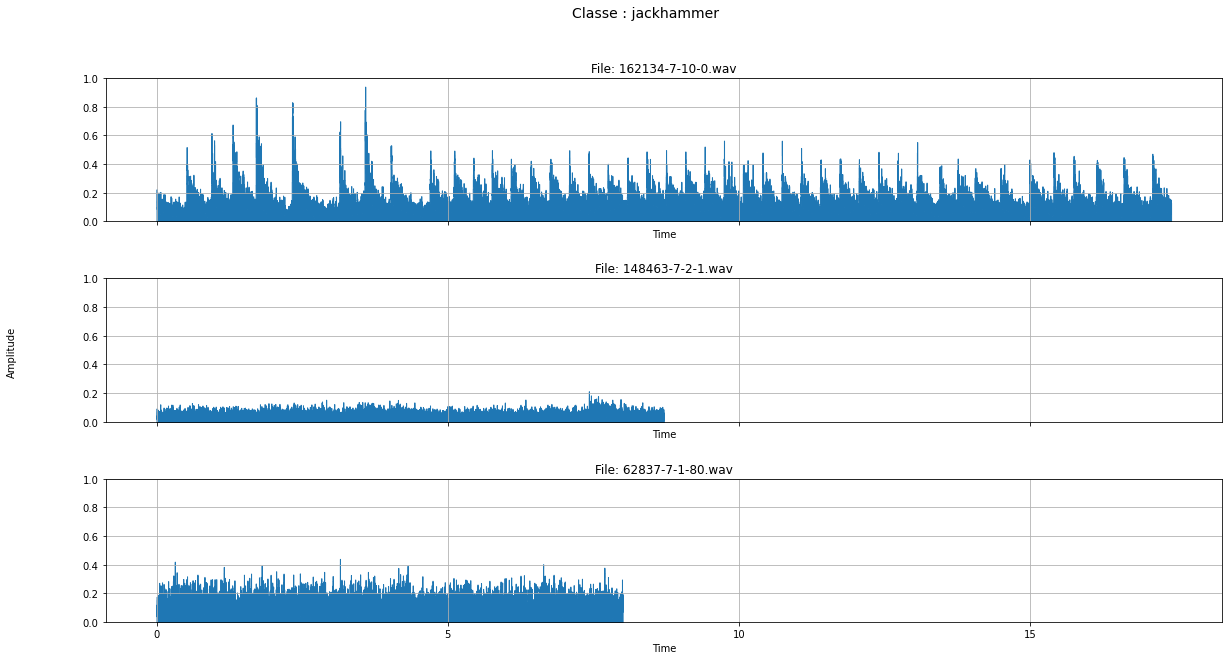

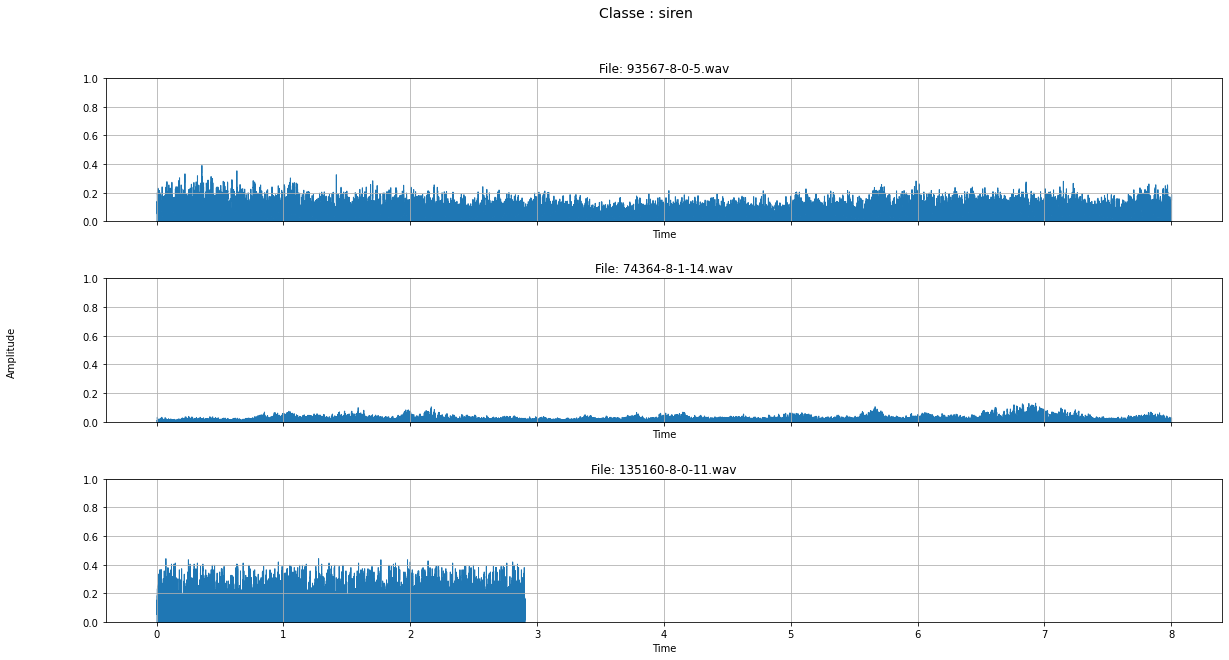

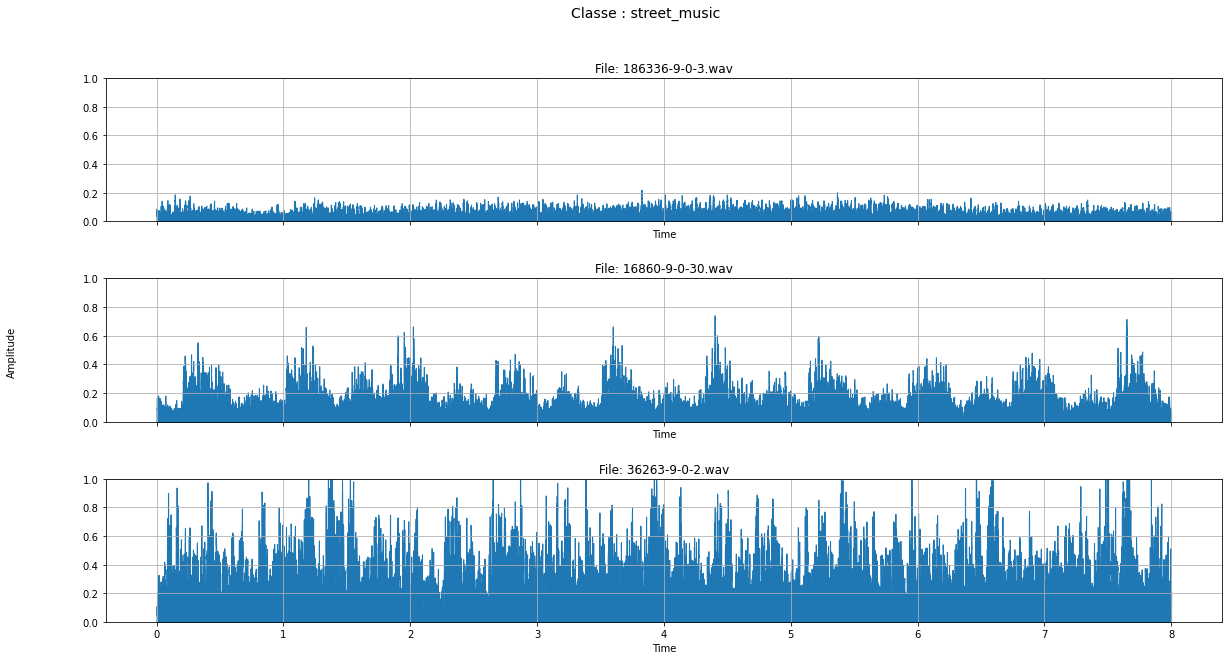

In [10]:
for i in range(10):
    plot_amplitude(i, 3)

Dans un premier temps, nous pouvons distinguer des sons périodiques comme **drilling**, **engine_idling** et **jackhammer** qui possèdent des pics d'amplitude à intervalles réguliers.

Nous pouvons cepedant observer que les niveaux d'amplitudes peuvent varier entre les différents échantillons d'une même classe de son.

Puis, nous observons que certains échantillons de classes de son différentes peuvent avoir des amplitudes similaires.

Ainsi, nous pouvons assez facilement déterminer que l'amplitude sonore n'est pas une caractéristique exploitable pour classifier divers sons. En effet, elle ne contient pas assez d'informations spécifiques permettant de pouvoir différencier les diverses classes de son.

### 6. Le dataset est-il équilibré ?

Text(0, 873.7, 'Moyenne = 873.20')

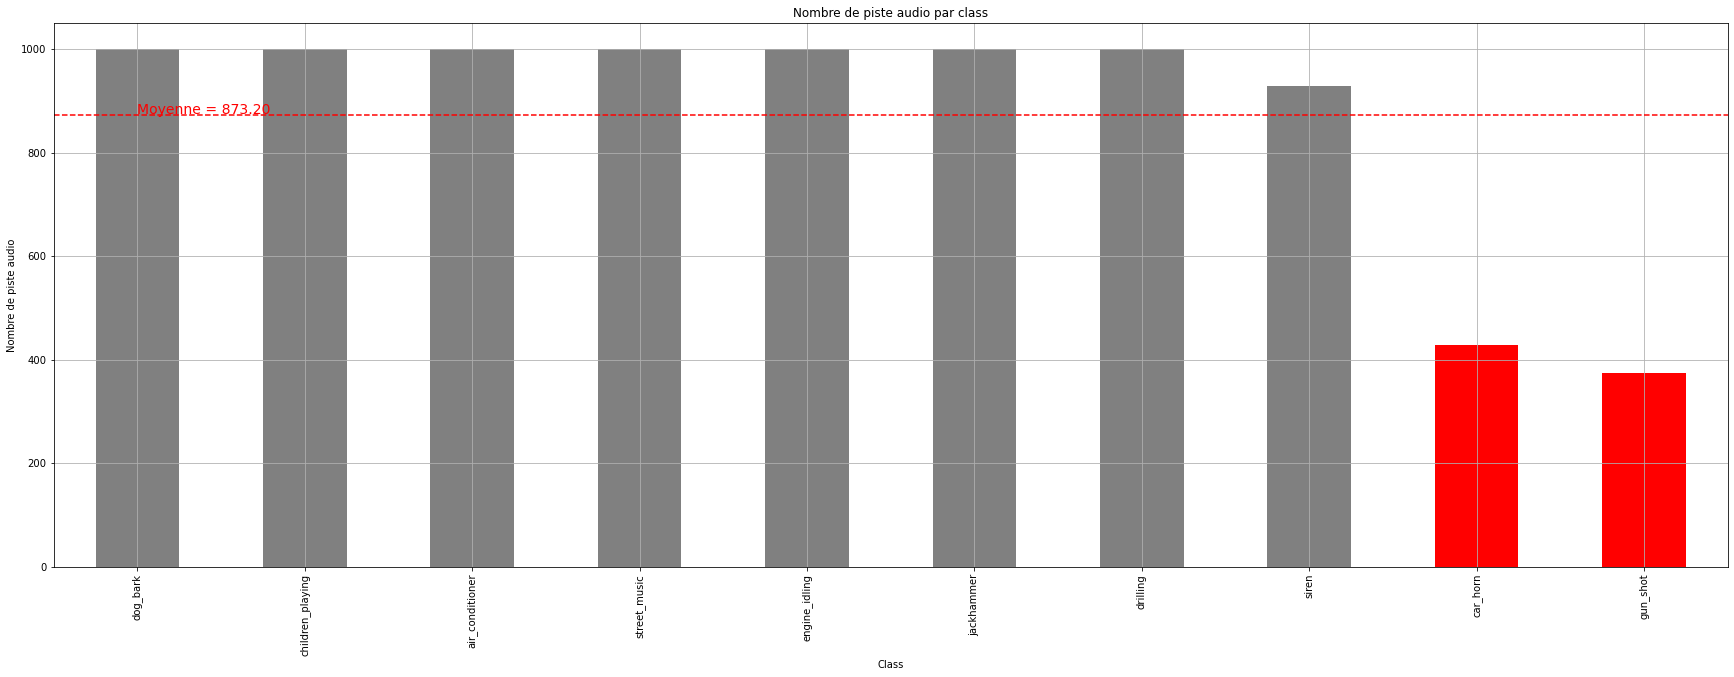

In [11]:
class_group = df['class'].value_counts()

mean = class_group.mean()
colors = ['gray' if x >= mean else 'r' for x in class_group]

plot = class_group.plot(
    kind='bar', 
    title="Nombre de piste audio par class", 
    figsize=(30,10),
    color=colors
)
plot.set_xlabel("Class")
plot.set_ylabel("Nombre de piste audio");
plot.grid(True)

plot.axhline(mean, color='red', linestyle='--')
plot.text(0, mean + 0.5, f'Moyenne = {mean:.2f}', color='red', fontsize=14)

* Le graphique ci-dessus révèle que 8 des 10 classes de son présentent un nombre d'échantillons identifiés d'une même ordre de grandeur (environ 1 000 chacune).
* <sup>Les 8 classes concernées sont : `Air Conditioner`, `Children Playing`,`Dog bark`, `Drilling`, `Engine Idling`, `Jackhammer`, `Siren` et `Street Music`</sup>
* Cependant le graphique révèle également que 2 des 10 classes de son présentent un nombre d'échantillons identifiés d'un ordre de grandeur différent (environ 400, soit environ 2,5 fois moins d'échantillons).
* <sup>Les 2 classes concernées sont : `Car horn` et `Gun shot`.</sup>
* Ainsi le dataset semble équilibré pour une partie des données, mais il est également déséquilibré en défaveur de 2 classes de son mentionnées ci-dessus.

### 7. Distribution du nombre de canaux de chaque son

Pour étudier la distribution du nombre de canaux, nous devons charger chaque son afin d'observer la variable `y` retournée par la fonction `load`.

1. Si la variable est de la forme `(n,)` alors cela signifie que le son est mono.
2. Si la variable est de la forme `(…, n)` alors cela signifie que le son est stéréo.

In [12]:
def load_sound_infos(file_name, fold, classID):
    
    s, sr = load_wave(str(fold),file_name)
    
    if s.shape[0] == 2:
        channel = 'stereo'
        num_channels = 2
        num_samples = s.shape[1]
    else:
        channel = 'mono'
        num_channels = 1
        num_samples = s.shape[0]
    return (file_name, fold, classID, channel, num_channels, num_samples, sr)

def get_more_infos_files(data):
    classIDs = data['classID'].unique()
    sounds = []
    for classID in classIDs:
        indices = np.where(data['classID'] == classID)[0]
        sounds_by_classID = data.iloc[indices]
        args = [(row['slice_file_name'], row['fold'], row['classID']) for _, row in sounds_by_classID.iterrows()]
        with multiprocessing.Pool() as pool:
            results = pool.starmap(load_sound_infos, args)
        sounds.extend(results)
    return sounds

In [13]:
files_extend = get_more_infos_files(df)

In [14]:
load_wave.cache_info()

CacheInfo(hits=0, misses=30, maxsize=None, currsize=30)

In [15]:
df_files =  pd.DataFrame(np.array(files_extend,dtype=object), columns=['file_name', 'fold', 'classID', 'channel_type', 'n_channels', 'audio_time_series', 'sample_rate'])
df_files.head()

,file_name,fold,classID,channel_type,n_channels,audio_time_series,sample_rate
0,100032-3-0-0.wav,5,3,stereo,2,14004,44100
1,100652-3-0-0.wav,2,3,stereo,2,176400,44100
2,100652-3-0-1.wav,2,3,stereo,2,176400,44100
3,100652-3-0-2.wav,2,3,stereo,2,176400,44100
4,100652-3-0-3.wav,2,3,stereo,2,176400,44100


In [16]:
df_files[['n_channels','channel_type']].value_counts()

n_channels  channel_type
2           stereo          7993
1           mono             739
dtype: int64

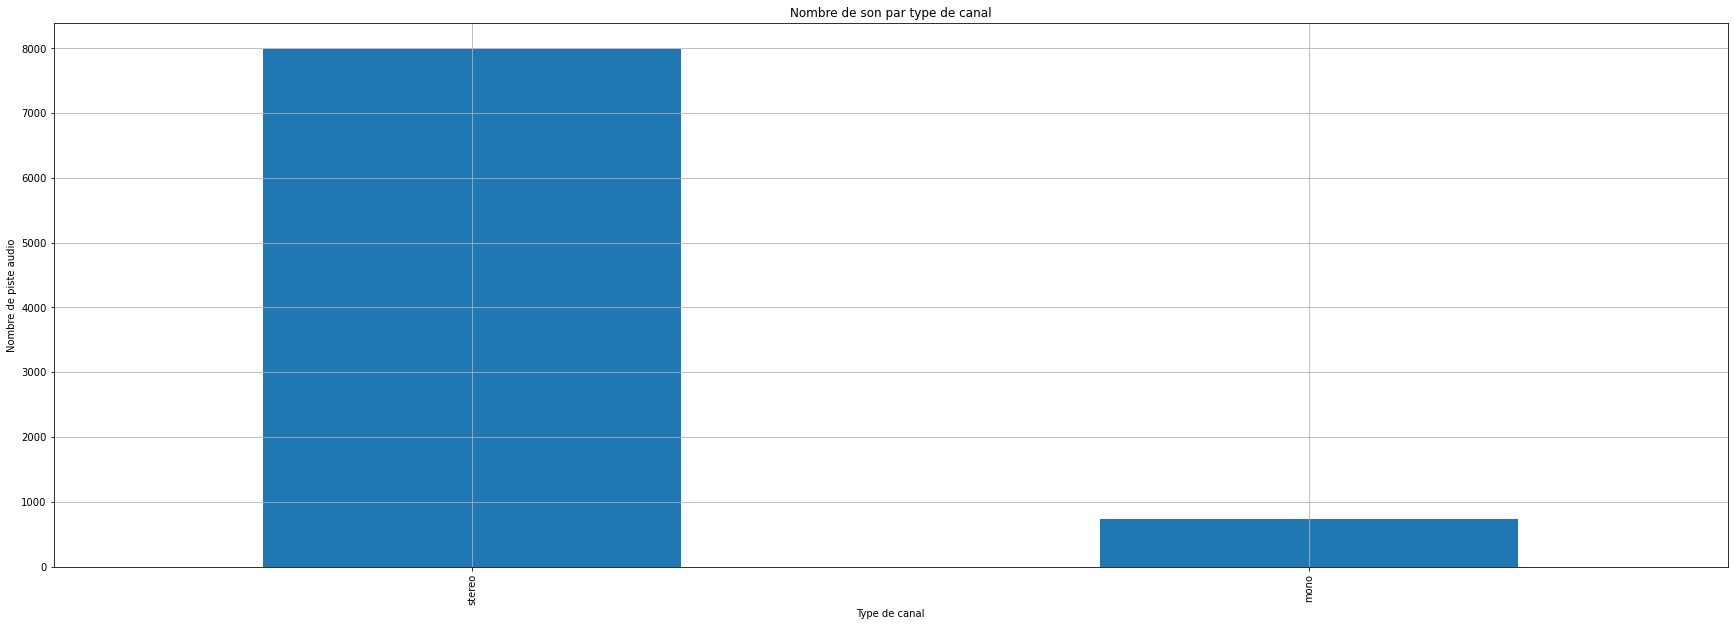

In [17]:
class_group = df_files['channel_type'].value_counts()
plot = class_group.plot(kind='bar', title="Nombre de son par type de canal", figsize=(30,10))
plot.set_xlabel("Type de canal")
plot.set_ylabel("Nombre de piste audio");
plot.grid(True)

Le graphique ci-dessus nous montre la répartition des échantillons par type de canal. On observe que la distribution est largement déséquilibrée en faveur du canal stéréo.

* Ceci n'est pas une bonne nouvelle, en effet, par la suite des problèmes pourraient être rencontrés, comme un manque de précision lors de la classification par exemple.
* En explorant la documentation de la librairie Librosa, il est conseillé de forcer l'exploitation des échantillions comme s'ils étaient tous avec le canal mono.

### 8. Distribution de la fréquence d'échantillonnage de chaque son

Nous allons observer grâce aux données obtenues précédemment l'ensemble des valeurs de la colonne `sample_rate`.

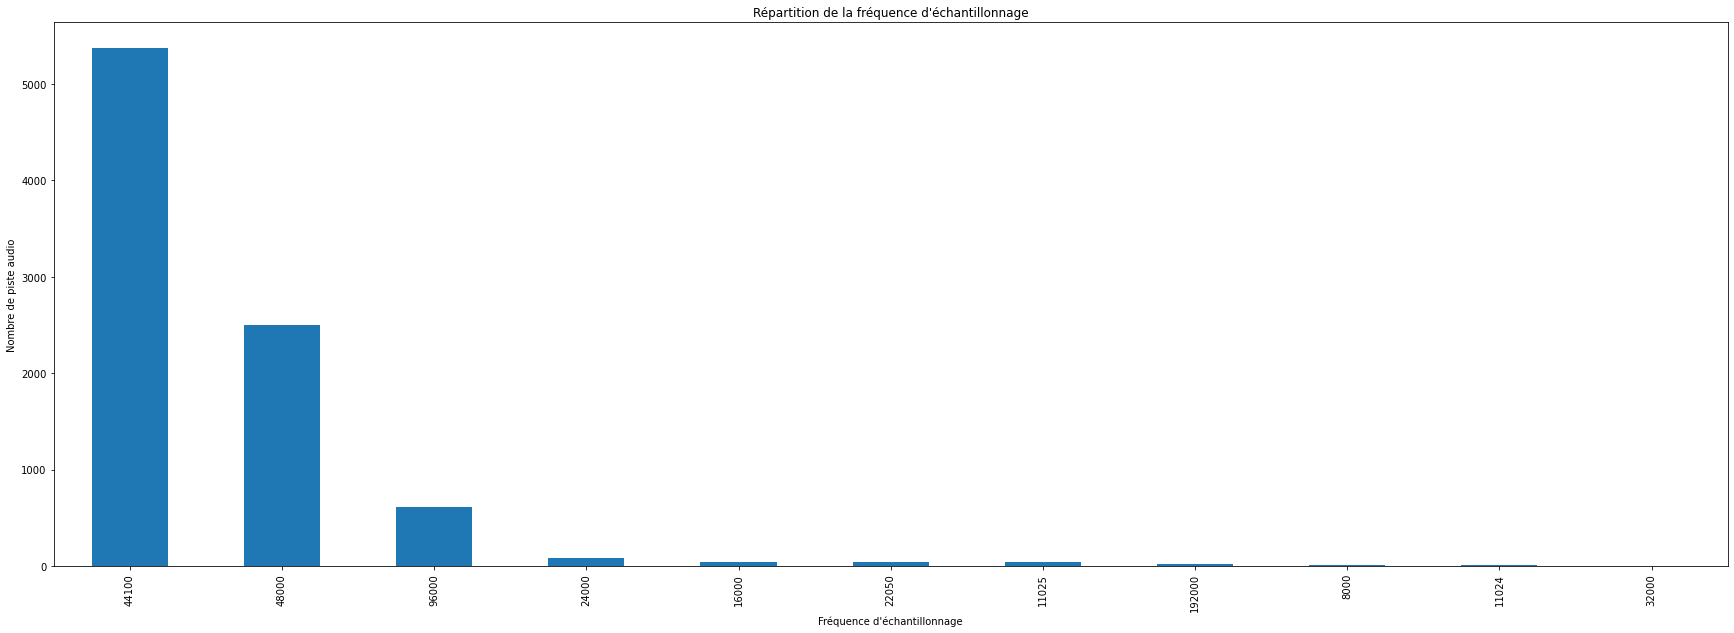

In [18]:
class_group = df_files['sample_rate'].value_counts()
plot = class_group.plot(kind='bar', title="Répartition de la fréquence d'échantillonnage",figsize=(30,10))
plot.set_xlabel("Fréquence d'échantillonnage")
plot.set_ylabel("Nombre de piste audio");
plot.grid(False)

* Les fréquences d'échantillonnage les plus utilisées sont `96kHz`, `48kHz` et `44,1kHz`. Ces fréquences sont assimilées à des fréquences d'enregistrements professionnels, ce qui signifie que la majorité des échantillons sont de très bonne qualité, ce qui pourra être un avantage lors de l'analyse pour la classification. Cependant leur bonne qualité est également synonyme de fichiers plus gros, et pourrons alors ralentir notre algorithme de classification.

* Une minorité d'échantillons utilisent les fréquences `32kHz` et moins, concidérées comme des fréquences "grand public", leurs analyses pourraient être impactées par cette différence de qualité.

* Il existe en revanche un faible nombre d'échantillons enregitrés avec une fréquences de `192kHz`.

* Deux solutions sont alors possibles : forcer l'utilisation de la fréquence d'échantillonnage `44,1kHz` puisqu'il est majoritaire, ou bien suivre le fonctionnement par défaut de la librairie Librosa qui propose par défaut l'utilisation de la fréquence `22,05kHz` correspondant à un format standard très populaire pour les sons de faible qualité.

### 9. Normalisation des variables étudiées par la librarie Librosa

Comme nous l'avons observé plus tôt, les échantillons sont soit de type mono soit de type stéréo.

* La librairie Librosa, grâce à la fonction *to_mono()*, nous permet de convertir les échantillons stéréo en mono.

* Pour normaliser la fréquence d'échantillonnage de chaque échantillon (ou sample rate), nous allons utiliser le paramètre `sr` de la fonction *load* en utilisant la valeur par défaut de `22050` (22,05kHz).

Ceci va nous permettre de définir le même taux d'échantillonnage pour tous les échantillons.

### 10. “Mel-spectogram“ et “Mel-frequency cepstral coefficients“

#### Mel-spectrogram

Le **Mel-spectrogram** est un type de représentation visuelle des données audio qui utilise le système auditif humain comme référence. Il se base sur la théorie que les fréquences audibles par l'oreille humaine ne sont pas perçues de manière uniforme mais sont plutôt regroupées en mélodies distinctes. Cette échelle de fréquences utilisée s'appelle l'échelle **Mel**, elle est basée sur la perception humaine de la fréquence et non sur une échelle linéaire en Hertz. Le signal audio est analysé en fréquences et chaque bande de fréquences est convertie en une intensité en dB, qui est ensuite représentée en couleur pour créer une image (HeatMap).

Il utilise une échelle de fréquences appelée échelle Mel, qui est basée sur la perception humaine de la fréquence et non sur une échelle linéaire en Hertz. Le signal audio est analysé en fréquences et chaque bande de fréquences est convertie en une intensité en dB, qui est ensuite représentée en couleur pour créer une image.

![image.png](https://miro.medium.com/max/1400/1*zX-rizZKXXg7Ju-entot9g.png)

**L'échelle Mel** est dérivée de l'étude de la psychologie de l'audition et de la perception de la fréquence. Elle a été développée pour refléter la façon dont l'oreille humaine perçoit les fréquences différemment selon leur valeur.
Elle est calculée de la manière suivante :

\begin{equation*}Mel(f)=295 log_{10} (1+\frac{f}{700})\end{equation*}

où $Mel(f)$ est l'échelle logarithmique de l'échelle de fréquence normale f. L'échelle Mel a un intervalle mel-fréquence constant, et couvre la gamme de fréquences de 0 Hz - 20050 Hz.

Ainsi les réseaux de neurones formés sur des Mel-spectrogrammes peuvent alors mieux comprendre les caractéristiques sonores qui sont importantes pour les tâches telles que la reconnaissance de la parole et la reconnaissance de la musique.


#### Mel-frequency cepstral coefficients (MFCCs)

Afin de comprendre ce que sont les **Mel-frequency cepstral coefficients**, il nous faut commencer par savoir ce que sont les **fréquences cepstrales** ainsi que la **Transformée de Fourier**.

Les **fréquences cepstrales** sont des représentations du signal audio qui capture les caractéristiques spectrales du signal audio en utilisant une transformation mathématique, comme la **Transformée de Fourier**.

La **Transformée de Fourier** est une technique mathéamtique pour étudier les propriétés spectrales des signaux audios et vidéos, mais également dans d'autre domaines. Elle permet de détecter les fréquences présentes dans un signal et des les isoler pour les étudier. La **Transformée de Fourier** connait deux types : La **Transformée de Fourier discrète (DFT)** et la **Transformée de Fourier continue (FT)**. La **DFT** est utilisée pour analyser des échantillons numériques, tandis que la **FT** est utilisée pour des signaux continus.

Dans notre contexte, la **DFT** sera le type utilisé. Sa définition pour un signal $s$ de $N$ échantillons est la suivante :

\begin{equation*}S(k)=\sum_{n=0}^{N-1} s(n)e^{-2\pi k \frac{n}{N}}\end{equation*}

Pour $0\le k<N$ Ainsi les **coefficients cepstraux de fréquence Mel** sont un type de représentation de la caractéristique du signal audio. Ils sont basés sur la transformation de **fréquences cepstrales** qui calcule les **coefficients cepstraux** à partir d'une décomposition en fréquence du signal comme expliqué plus-tôt. Cette fréquence est ensuite appliquée sur l'échelle de fréquence **Mel**. Cette représentation permet de capturer les caractéristiques spectrales du signal audio, telles que les **formants**, qui sont important dans la reconnaissances de la parole et l'analyse audio.
Ces coefficients sont utilisés pour nourrir divers algorithmes permettant la classification audio par exemple.

### 11. Construction du dataframe pandas qui va contenir les MFCCs et les labels de chaque échantillon.

#### Exemple d'extraction MFCC

**Méthode**

Nous allons utiliser les procédures détaillées dans la librairie Librosa.

1. Parcourir toutes les pistes audio en  normalisant :
   * *Le nombre de canaux* :`to_mono(...)` Mono.
   * *Les fréquence d'échantillonnage* :`resample(...)` Methode de Fourier car le signal est périodique voir [scipy.signal.resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample), 
2. Extraction de la feature MFCCs :
    * *Param1* : le nombre de filtre de mels `n_mels`. Nous utiliserons 20 dans notre cas.
    * *Param2* : le mode de padding `pad_mode` on utilisera `constant` qui mettra des zero sur les paddings.
    * On fixera la taille des mfcc à 900 avec la fonction `fix_length`, car leur taille varies entre différentes observations.
3. On encodera les labels en valeurs categoricales.
4. Ensuite on rajoutera les valeurs MFCCs obtenues au dataframe qui seront nettoyer et reshape .

In [77]:
RATE = 22050                             # Définir la fréquence d'échantillonnage cible
N_MFCC = 20                              # Nombres de filtre de mels max 20
MFCC_MAX_LEN = 900                       # Max len

file = get_sample_by_classId(df,1,6)    # Random fichier par class

fold = file[0][0]
file_name = file[0][1]
y, sr = load_wave(str(fold),file_name)              # Chargment du fichier
print(f"Fichier ==> fold{fold}/{file_name}")

Fichier ==> fold5/162432-6-6-0.wav


In [78]:
# Normalisation des canaux ou mono = True dans le load
y_mono = lisa.to_mono(y)

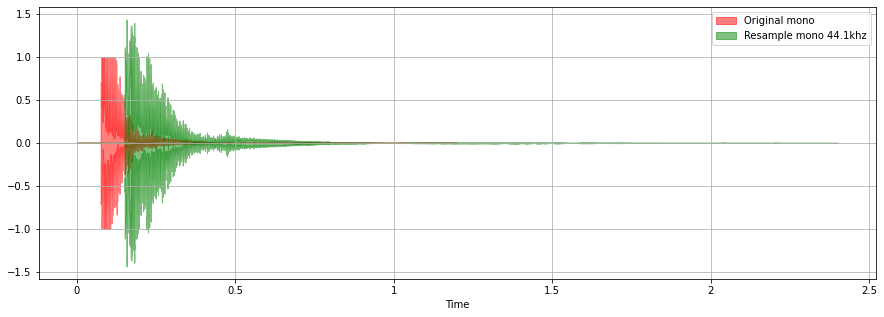

In [79]:
# Normalization sample rate 441000
y_rsmple = lisa.core.resample(y=y_mono,orig_sr=sr,target_sr=44100, scale=True)

plt.figure(figsize=(15,5))
lisa.display.waveshow(y, sr=sr, color='r', label="Original mono", alpha=0.5 )
lisa.display.waveshow(y_rsmple, sr=RATE, color='g', label="Resample mono 44.1khz", alpha=0.5)
plt.legend()
plt.show()

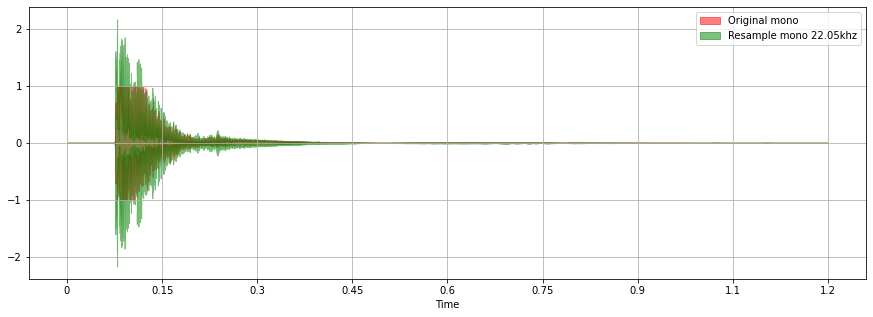

In [80]:
# Normalization sample rate 22050
y_rsmple = lisa.core.resample(y=y_mono,orig_sr=sr,target_sr=RATE, scale=True)

plt.figure(figsize=(15,5))
lisa.display.waveshow(y, sr=sr, color='r', label="Original mono", alpha=0.5 )
lisa.display.waveshow(y_rsmple, sr=RATE, color='g', label="Resample mono 22.05khz", alpha=0.5)
plt.legend()
plt.show()

No padding shape :(20, 52)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


[Text(0.5, 1.0, 'MFCCs')]

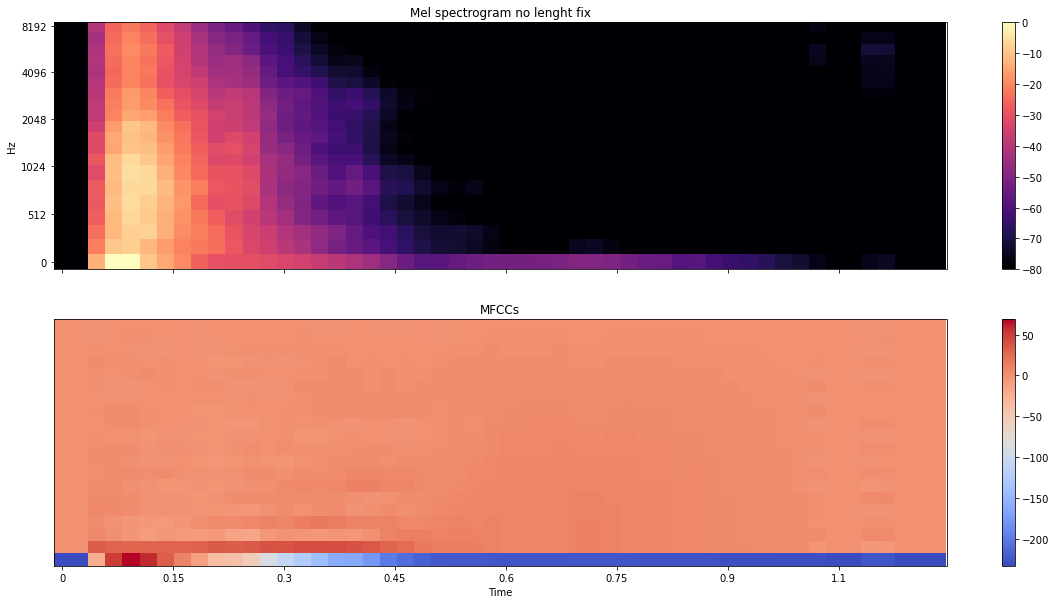

In [82]:
S = lisa.feature.melspectrogram(y=y_rsmple, sr=RATE, n_mels=N_MFCC, fmax=8000,center=True, pad_mode="constant")

# No length normalize
mfccs_no_pad = lisa.feature.mfcc(S=lisa.power_to_db(S))
print(f"No padding shape :{mfccs_no_pad.shape}" )


# Plot https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(20,10))

plt.grid(False)
img = lisa.display.specshow(lisa.power_to_db(S, ref=np.max), 
                            x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram no lenght fix')
ax[0].label_outer()

img = lisa.display.specshow(mfccs_no_pad, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCCs')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


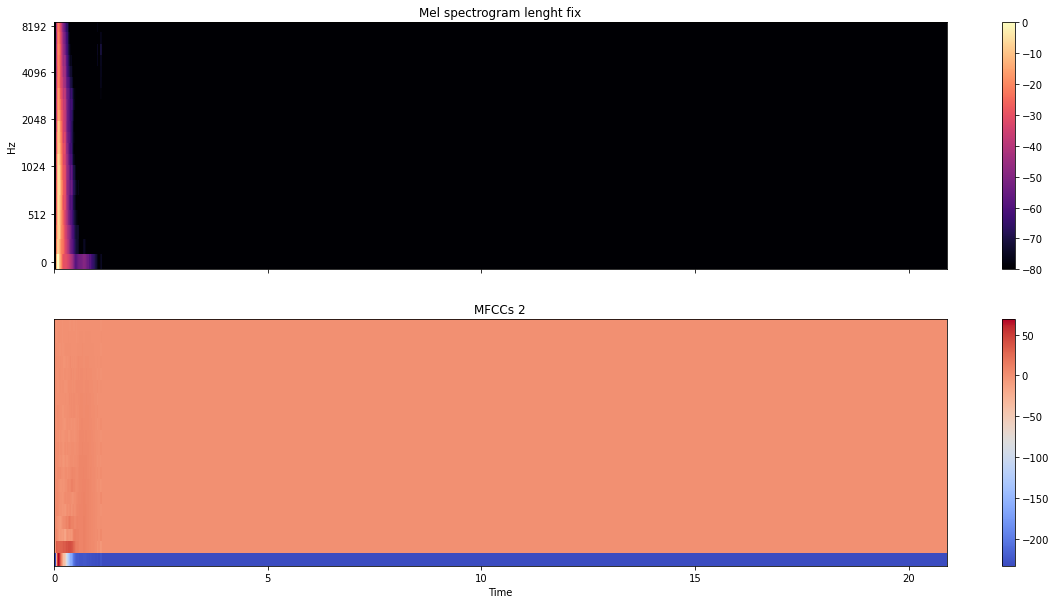

Shape (20, 900)


In [83]:

# length normalize
S_pad = librosa.util.fix_length(S,size=MFCC_MAX_LEN, mode='constant')
mfccs_pad = lisa.feature.mfcc(S=lisa.power_to_db(S_pad))

fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(20,10))
img2 = lisa.display.specshow(lisa.power_to_db(S_pad, ref=np.max), 
                            x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])
fig.colorbar(img2, ax=[ax[0]])
ax[0].set(title='Mel spectrogram lenght fix')
ax[0].label_outer()

img3 = lisa.display.specshow(mfccs_pad, x_axis='time', ax=ax[1])
fig.colorbar(img3, ax=[ax[1]])
ax[1].set(title='MFCCs 2')
plt.show()
print(f"Shape {mfccs_pad.shape}")

### Fonction d'extraction

Nous allons maintenant écris les fonctions qui vont nous permettres d'automatisé l'extraction des features mfccs.

In [25]:
def resample_sound(y, orig_sr, target_sr):
    y = lisa.core.resample(y=y, orig_sr=orig_sr, target_sr=target_sr, scale=True)
    return y

def extract_mfcc_features(wav, sr, sr_target=RATE, n_mfcc=N_MFCC, mono=True, padding='constant'):
    '''
    Extraire la feature mfcc pour tout le data frame,
    Appliquera les normalisations de sample rate et mono
    :return: 2d numpy array MFCC
    '''
    y = wav
    if mono : y = lisa.to_mono(y)
        
    # Normalization sample rate 
    # Use the resample_sound function and cache the results
    y = resample_sound(y, sr, sr_target)
    
    # Extraction de la feature LM
    S = lisa.feature.melspectrogram(y=y, sr=sr_target, n_mels=n_mfcc, center=True, pad_mode=padding)
    
    
    S_pad = librosa.util.fix_length(S,size=MFCC_MAX_LEN, mode='constant')
    
    mfccs = lisa.feature.mfcc(S=lisa.power_to_db(S_pad))
    
    return mfccs

In [26]:
def row_parser(row, sr_target=RATE, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Parser chaque ligne en extrayant la feature mfcc du son
    et le label
    :return: label, mfcc feature(2d numpy array)
    '''
    folder = str(row['fold']);
    file_name = row['slice_file_name']
    label = row['classID']
    
    # Use the load_wave function and cache the results
    wave, sr = load_wave(folder, file_name)
    
    mfccs = extract_mfcc_features(wave, sr, sr_target, n_mfcc, mono, padding)
    
    return label, mfccs

In [56]:
def build_feature_df(df, n_mfcc=N_MFCC, mono=True, padding='linear_ramp', max_len=MFCC_MAX_LEN):
    '''
    Construire le dataframe avec les feature extraites.
    :param df: dataframe de base
    :param sr: sample rate,
    :param n_mfcc: nombre de filtre de mels
    :param mono: mono normalisation
    :param padding: padding mode
    
    Return
    -----
    
    df_new: mfcc et label sans normalisation
    df_new_mean : mfcc et label avec normalisation
    '''
    
    y =  []
    X = []
    
    mfcc_cols = ["mfcc" + str(i) for i in range(N_MFCC)]    
    df_new_mean = pd.DataFrame(columns=mfcc_cols)
    
    
    # Extraction des mfccs
    for index in trange(len(df)):
        # extaction des mfcc et label
        l , mfccs = row_parser(df.iloc[index])
        
        # METHOD1 : Prendre la moyenne pour chaque feature        
        # Use the mean method of the DataFrame class instead of creating a new DataFrame
        mfcc_df_mean = pd.DataFrame(mfccs).mean(axis=1).to_frame().T
        mfcc_df_mean.columns = mfcc_cols
        df_new_mean = pd.concat([df_new_mean, mfcc_df_mean], ignore_index=True)
        
        # METHOD2
        # Use np.clip to limit the length of the mfccs array
        mfccs = mfccs[:, :np.clip(max_len, 0, mfccs.shape[1])]
        
        # Use np.pad only if necessary (TODO : plus besoin à partir du moment ou)
        if (max_len > mfccs.shape[1]):
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        X.append(mfccs)
        y.append(l)
    
       
    df_new_mean['target'] = y    
    return df_new_mean, X, y
    

In [57]:
def plot_history_perf(history):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

In [59]:
df_new_mean , X_mfcc, y_label = build_feature_df(df)

  0%|          | 0/8732 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


In [64]:
# DF2 MFCC avec moyenne (Utilisé pour les models simple)
df_new_mean.describe()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,target
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,...,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,-251.405380,7.580608,-1.220261,0.887083,-0.236844,0.518645,0.108368,0.300765,-0.012871,0.212941,...,0.160935,-0.025039,0.120970,0.005399,0.079921,-0.006537,0.050681,-0.013227,0.012233,4.592877
std,40.115833,4.225147,2.384287,1.443020,1.075999,0.922544,0.843395,0.700179,0.622802,0.537005,...,0.425471,0.373296,0.323801,0.280440,0.250452,0.232856,0.221014,0.186158,0.190516,2.894544
min,-433.690247,-5.029562,-12.924432,-4.421931,-5.694142,-5.088862,-3.800499,-2.914742,-4.844826,-2.644281,...,-2.216522,-2.511123,-1.968762,-1.602281,-1.133091,-1.227356,-1.199551,-1.326007,-1.694126,0.000000
25%,-273.888283,4.510988,-2.327456,0.059341,-0.827342,-0.007497,-0.357669,-0.078395,-0.318426,-0.079184,...,-0.059883,-0.206114,-0.052817,-0.145479,-0.045774,-0.132932,-0.054663,-0.104707,-0.070338,2.000000
50%,-246.152481,8.120332,-0.818580,0.849470,-0.129021,0.480505,0.075258,0.237171,-0.013558,0.183456,...,0.140867,-0.025122,0.105908,0.004183,0.074820,-0.004768,0.037347,-0.002971,0.011545,4.000000
75%,-223.976288,10.589821,0.161517,1.761212,0.428336,1.061038,0.592498,0.677903,0.314597,0.525672,...,0.384269,0.157542,0.303784,0.152831,0.216273,0.107938,0.159125,0.085695,0.095490,7.000000
max,-157.935516,22.042267,7.144463,9.019155,4.117723,4.828973,6.084194,4.101400,3.018663,3.307551,...,2.828600,2.435403,2.216830,2.516301,1.936215,1.292334,1.295608,1.151456,1.098851,9.000000


**NOTES**
- Nous avons extrait les features mfcc.
- Il ya deux methode une avec la moyenne pour chaque mfcc (celle que l'on peut trouver partout sur internet), et l'autre qui ajoute les mfcc tel qu'ils sont.


## 12. Séparer les données en un jeu d'entraînement/validation et un jeu de test.

In [111]:
target = "target"

# J'utilise avec mean ici
X = df_new_mean.iloc[:,:-1]
y = df_new_mean['target']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [113]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

## 13. Premier réseau de neurones

Vu au jour 4 du cours, à retravailler pour l'adapter au projet

In [114]:
input_dim  = X_train.shape[1] # Nombre de variables en entrée du réseau
print(input_dim)

20


In [115]:
def create_linear_model():
    model = Sequential()    
    model.add(Dense(32, input_dim = input_dim, activation = "relu"))
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = "adam",loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

In [116]:
linear_model = create_linear_model()

In [117]:
linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________


## 14. Entraînement du modèle construit et mesurer sa performance.

In [119]:
checkpoint_cb = ModelCheckpoint("model1.h5",save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10,restore_best_weights=True)    

In [120]:
nb_epochs = 100
history = linear_model.fit(x = X_train,y = y_train,
                    epochs = nb_epochs,validation_data = (X_val, y_val),
                    batch_size = 32, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 7.7028 - accuracy: 0.1749 - val_loss: 2.1608 - val_accuracy: 0.2416
Epoch 2/100
164/164 [==============================] - 0s 2ms/step - loss: 2.0533 - accuracy: 0.2722 - val_loss: 1.9606 - val_accuracy: 0.3137
Epoch 3/100
164/164 [==============================] - 0s 2ms/step - loss: 1.9056 - accuracy: 0.3221 - val_loss: 1.8528 - val_accuracy: 0.3589
Epoch 4/100
164/164 [==============================] - 0s 2ms/step - loss: 1.8208 - accuracy: 0.3658 - val_loss: 1.8100 - val_accuracy: 0.3406
Epoch 5/100
164/164 [==============================] - 0s 2ms/step - loss: 1.7638 - accuracy: 0.3824 - val_loss: 1.7276 - val_accuracy: 0.3749
Epoch 6/100
164/164 [==============================] - 0s 2ms/step - loss: 1.7628 - accuracy: 0.3855 - val_loss: 1.8401 - val_accuracy: 0.3686
Epoch 7/100
164/164 [==============================] - 0s 2ms/step - loss: 1.7124 - accuracy: 0.4040 - val_loss: 1.7277 - val_accuracy: 0.4007

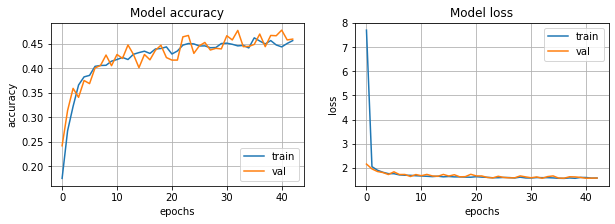

In [121]:
plot_history_perf(history)

In [122]:
_, accuracy = linear_model.evaluate(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

55/55 [==============================] - 0s 1ms/step - loss: 1.5873 - accuracy: 0.4614
Accuracy: 46.14%


## 15. Réseau de neurones convolutif (couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées)

In [127]:
X = np.array(X_mfcc)
y = np.array(y_label)
y = to_categorical(y)

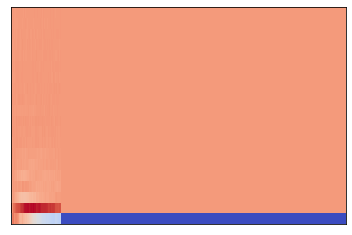

In [128]:
img = lisa.display.specshow(X[1000])
plt.show()

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=True, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=True)

In [130]:
X_train.shape

(5238, 20, 900)

In [131]:
feature_dim_1 = N_MFCC
feature_dim_2 = MFCC_MAX_LEN
channel = 1

input_shape = (feature_dim_1, feature_dim_2, channel)

In [132]:
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_val = X_val.reshape(X_val.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

In [133]:
print(X_train.shape)
print(y_train.shape)

(5238, 20, 900, 1)
(5238, 10)


In [134]:
print(X_val.shape)
print(y_val.shape)

(1747, 20, 900, 1)
(1747, 10)


In [135]:
print(X_test.shape)
print(y_test.shape)

(1747, 20, 900, 1)
(1747, 10)


In [136]:
y_train_d = y_train
y_test_d = y_test

In [ ]:

def create_convolution_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
conv_model1 = create_convolution_model()

In [ ]:
conv_model1.summary()

## 16. Entraînement du modèle construit et mesurer sa performance.

In [ ]:
history1 = conv_model1.fit(X_train, y_train, epochs=10, batch_size=50, validation_data=(X_val, y_val))

In [ ]:
plot_history_perf(history1)

In [ ]:
test_loss, test_acc = conv_model.evaluate(X_test, y_test, verbose=2)

**NOTES**
* Précision 75 % avec 10 epochs
* Trop long au training.

## 17. Test de différentes structures et différentes valeurs des hyperparamètres

Model inspiré de l'article "Environment Sound Classification Using a Two-Stream CNN Based on Decision-Level Fusion" [12].
Par rapport au model précédent nous avons : 
- Un kernel plus grand, pour capturer plus de features dans l'image.
- Utilisationd de BatchNormalization après chaque couche de convolution pour normaliser les entrées et accélérer le processus de formation.
- Utilisation d'un régularisateur l2, qui peut réduit l'excès d'ajustement (overfitting) en pénalisant les poids trop élevés ou à la fois les poids et les biais.

In [102]:
def create_convolution_model_2():
    model = Sequential()
    
    # Ajouter la première couche avec 32 noyaux de taille 3x3 et de stride 2x2
    model.add(Conv2D(32, (3, 3), padding="same", strides=(2, 2), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Ajouter la deuxième couche avec 32 noyaux de taille 3x3 et de stride 2x2
    model.add(Conv2D(32, (3, 3), padding="same", strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # Ajouter la troisième couche avec 64 noyaux de taille 3x3 et stride 2x2
    model.add(Conv2D(64, (3, 3), padding="same", strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Ajouter la quatrième couche avec 64 noyaux de taille 3x3 et stride 2x2
    model.add(Conv2D(64, (3, 3), padding="same", strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5)) # Add dropout with probability of 0.5

    # Aplatir la sortie de la dernière couche convolutionnelle
    model.add(Flatten())

    # Ajoutez la cinquième couche comme une couche entièrement connectée avec 1024 unités et une activation sigmoïde.
    model.add(Dense(1024))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5)) 

    # Ajouter la couche de sortie avec dix unités et l'activation softmax
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # Paramètres de l'optimiseur
    optimizer = Adam(lr=0.001, decay=1e-6)
    regularizer = l2(l=0.01)                       # Appliquer la régularisation L2 à tous les paramètres de poids
    loss = categorical_crossentropy                # Utiliser l'entropie croisée comme fonction de perte

    batch_size =32
    metrics=['accuracy']
    momentum=0.9

    # Compiler le modèle en utilisant les paramètres ci-dessus.
    print("Compiling model...")
    start_time = time.time()

    try:
        model.compile(loss=loss, optimizer=optimizer,metrics=metrics)
    except Exception as e:
        print(e)
        sys.exit(-1)

    end_time = time.time()
    print("Model compiled in {0} seconds".format(end_time - start_time))
    
    return model

In [103]:
conv_model2 = create_convolution_model_2()

Compiling model...
Model compiled in 0.008301734924316406 seconds


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [104]:
conv_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 450, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 450, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 10, 450, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 225, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 225, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 5, 225, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 112, 32)       

In [108]:
checkpoint_m3 = ModelCheckpoint("model2.h5",save_best_only=True)
early_stopping_m3 = EarlyStopping(patience=20,restore_best_weights=True) 

history2 = conv_model2.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val) 
                           ,callbacks=[checkpoint_m3, checkpoint_m3])

Epoch 1/60
164/164 [==============================] - 13s 78ms/step - loss: 0.2314 - accuracy: 0.9189 - val_loss: 0.3645 - val_accuracy: 0.8867
Epoch 2/60
164/164 [==============================] - 12s 76ms/step - loss: 0.2481 - accuracy: 0.9120 - val_loss: 0.3713 - val_accuracy: 0.8872
Epoch 3/60
164/164 [==============================] - 13s 81ms/step - loss: 0.2462 - accuracy: 0.9143 - val_loss: 0.4022 - val_accuracy: 0.8912
Epoch 4/60
164/164 [==============================] - 13s 76ms/step - loss: 0.2496 - accuracy: 0.9150 - val_loss: 0.3567 - val_accuracy: 0.8947
Epoch 5/60
164/164 [==============================] - 13s 81ms/step - loss: 0.2379 - accuracy: 0.9170 - val_loss: 0.3798 - val_accuracy: 0.8872
Epoch 6/60
164/164 [==============================] - 13s 77ms/step - loss: 0.2468 - accuracy: 0.9089 - val_loss: 0.3565 - val_accuracy: 0.8930
Epoch 7/60
164/164 [==============================] - 13s 77ms/step - loss: 0.2352 - accuracy: 0.9194 - val_loss: 0.4165 - val_accuracy:

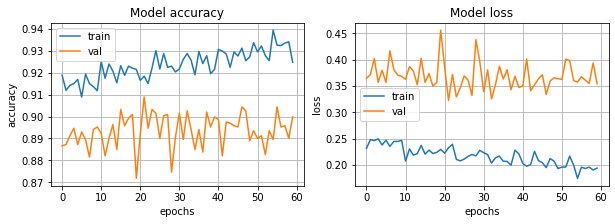

In [138]:
plot_history_perf(history2)

In [ ]:
test_loss, test_acc = conv_model2.evaluate(X_test, y_test, verbose=2)

In [124]:
def create_convolution_model_3():
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), padding="same", strides=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Conv2D(32, (5, 5), padding="same", strides=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (5, 5), padding="same", strides=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Conv2D(64, (5, 5), padding="same", strides=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5)) 

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    optimizer = Adam(lr=0.001, decay=1e-6)
    regularizer = l2(l=0.01)                       
    loss = categorical_crossentropy                

    batch_size =32
    metrics=['accuracy']
    momentum=0.9

    print("Compiling model...")
    start_time = time.time()

    try:
        model.compile(loss=loss, optimizer=optimizer,metrics=metrics)
    except Exception as e:
        print(e)
        sys.exit(-1)

    end_time = time.time()
    print("Model compiled in {0} seconds".format(end_time - start_time))
    
    return model

In [125]:
conv_model3 = create_convolution_model_3()

Compiling model...
Model compiled in 0.005872964859008789 seconds


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [126]:
conv_model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 7, 300, 32)        832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 300, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 7, 300, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 100, 32)        25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 100, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 3, 100, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 50, 32)        

In [137]:
checkpoint_m4 = ModelCheckpoint("model3.h5",save_best_only=True)
early_stopping_m4 = EarlyStopping(patience=20,restore_best_weights=True) 

history3 = conv_model3.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val) 
                           ,callbacks=[checkpoint_m4, early_stopping_m4])

Epoch 1/60
164/164 [==============================] - 9s 50ms/step - loss: 2.1379 - accuracy: 0.2352 - val_loss: 1.7421 - val_accuracy: 0.3904
Epoch 2/60
164/164 [==============================] - 7s 45ms/step - loss: 1.7301 - accuracy: 0.3786 - val_loss: 1.5749 - val_accuracy: 0.4545
Epoch 3/60
164/164 [==============================] - 8s 49ms/step - loss: 1.5455 - accuracy: 0.4404 - val_loss: 1.4414 - val_accuracy: 0.5003
Epoch 4/60
164/164 [==============================] - 7s 44ms/step - loss: 1.4246 - accuracy: 0.4861 - val_loss: 1.4880 - val_accuracy: 0.4734
Epoch 5/60
164/164 [==============================] - 7s 43ms/step - loss: 1.3044 - accuracy: 0.5281 - val_loss: 1.2371 - val_accuracy: 0.5695
Epoch 6/60
164/164 [==============================] - 7s 43ms/step - loss: 1.2469 - accuracy: 0.5462 - val_loss: 1.3838 - val_accuracy: 0.5140
Epoch 7/60
164/164 [==============================] - 8s 48ms/step - loss: 1.1838 - accuracy: 0.5779 - val_loss: 1.5059 - val_accuracy: 0.4900

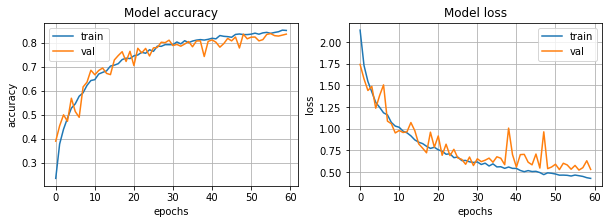

In [141]:
plot_history_perf(history3)

In [142]:
test_loss, test_acc = conv_model3.evaluate(X_test, y_test, verbose=2)

55/55 - 1s - loss: 0.4775 - accuracy: 0.8449


## 18. Meilleur modèle

**NOTES** :

* ...
* ...
* ...

## Acknowledgements

* **[1]** J. Salamon, C. Jacoby and J. P. Bello, **"A Dataset and Taxonomy for Urban Sound Research"**, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.
* **[2]** Wikipedia contributors. (2023, January 5). WAV. Wikipedia. https://en.wikipedia.org/wiki/WAV
* **[3]** Wikipedia contributors. (2023b, January 16). Waveform Audio File Format. https://fr.wikipedia.org/wiki/Waveform_Audio_File_Format
* **[4]** Hwung, C. (2022, June 4). WAV Files: File Structure, Case Analysis and PCM Explained. https://www.videoproc.com/resource/wav-file.htm
* **[5]** Sound - Frequency, Wavelength and Octave. (n.d.). https://www.engineeringtoolbox.com/sound-frequency-wavelength-d_56.html
* **[6]** Amplitude : définition et explications. (n.d.). Techno-Science.net. https://www.techno-science.net/definition/1231.html
* **[7]** V., M. (2022, June 28). What Is Sample Rate In Audio? ( Depths, Quality, Bit Rate ). Hip Hop Makers. https://hiphopmakers.com/what-is-sample-rate-in-audio
* **[8]** Mel Spectrogram Explained with Python Code. (2022, June 10). Amir Masoud Sefidian. [link](http://sefidian.com/2022/03/24/mel-spectrogram-explained-with-python-code/#:~:text=A%20mel%20spectrogram%20is%20a%20spectrogram%20where,the%20frequencies%20are%20converted%20to%20the%20mel%20scale).
* **[9]** Contributeurs aux projets Wikimedia. (2022, December 17). Échelle des mels. https://fr.wikipedia.org/wiki/%C3%89chelle_des_mels
* **[10]** Contributeurs aux projets Wikimedia. (2022a, April 8). Spectrogramme. https://fr.wikipedia.org/wiki/Spectrogramme
* **[11]** Min Xu; et al. (2004). ["HMM-based audio keyword generation"](https://web.archive.org/web/20070510193153/http://cemnet.ntu.edu.sg/home/asltchia/publication/AudioAnalysisUnderstanding/Conference/HMM-Based%20Audio%20Keyword%20Generation.pdf) . In Kiyoharu Aizawa; Yuichi Nakamura; Shin'ichi Satoh (eds.). Advances in Multimedia Information Processing – PCM 2004: 5th Pacific Rim Conference on Multimedia. Springer. ISBN 978-3-540-23985-7.
* **[12]** Sahai, H. (n.d.). MFCC (Mel Frequency Cepstral Coefficients) for Audio format. OpenGenus IQ: Computing Expertise & Legacy. https://iq.opengenus.org/mfcc-audio/
* **[13]**  Su, Y.; Zhang, K.; Wang, J.; Madani, K. Environment Sound Classification Using a Two-Stream CNN Based on Decision-Level Fusion. Sensors 2019, 19, 1733. https://doi.org/10.3390/s19071733
* **[14]** Inspired by [PRABHAV SINGH](https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook)